In [48]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model
import moviepy.editor as mpe
import subprocess

In [49]:
IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('model/shape_predictor_68_face_landmarks.dat')

model = load_model('model/videoopencv.h5')
#model.summary()

In [50]:
def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]
    margin_x, margin_y = w / 2, h / 2
    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)
    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)
    eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]
    return eye_img, eye_rect

In [51]:
def get_mspec(movie):
    length = int(movie.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = movie.get(cv2.CAP_PROP_FPS)
    return length, width, height, fps

In [52]:
def convert_video(video_input, video_output):
    cmds = ['ffmpeg', '-i', video_input, '-r', '24', video_output]
    p = subprocess.Popen(cmds, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

In [53]:
# main

# 눈깜빡임 수를 담을 변수
frame_counter = 1
frame_index = []
blink_counter = 0
blink_check = True
blinking = 0

#영상파일 이름
video_input = "data/jinwoo0766.mp4"
video_output = "data/jinwoo0766_24fps.mp4"
resultpath = "data/jinwoo0766_24fps_result.mp4"

convert_video(video_input, video_output)

cap = cv2.VideoCapture(video_output)
cap_length, cap_width, cap_height, cap_fps_n = get_mspec(cap)
print(cap_length, cap_width, cap_height, cap_fps_n)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(resultpath, fourcc, cap_fps_n, (cap_width//2, cap_height//2))

1837 720 404 24.0


In [54]:
while cap.isOpened():
    
    ret, img_ori = cap.read()
    
    #frame이 정상적으로 받아지는지 체크
    if not ret:
        break

    # frame resizing
    img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)
    img = img_ori.copy()
    
    if frame_counter==1:
        img_with_box=img

    # 분석할 프래임 선택 작업 (둘 중에 1개 분석하지 않음)
    if frame_counter%2!=0:
    
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        for face in faces:
            shapes = predictor(gray, face)
            shapes = face_utils.shape_to_np(shapes)

            eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
            eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

            eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
            eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
            eye_img_r = cv2.flip(eye_img_r, flipCode=1)

#            cv2.imshow('lefteye', eye_img_l)
#            cv2.imshow('righteye', eye_img_r)

            eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
            eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

            pred_l = model.predict(eye_input_l)
            pred_r = model.predict(eye_input_r)

            # visualize
            CNST = 0.01
            state_l = 'O %.1f' if pred_l > CNST else '- %.1f'
            state_r = 'O %.1f' if pred_r > CNST else '- %.1f'

            if pred_l < CNST and pred_r < CNST:
                blinking = 1
                if blink_check:
                    blink_check=False
                    blink_counter += 1
            else:
                blinking = 0
                blink_check=True

            state_l = state_l % pred_l
            state_r = state_r % pred_r

            cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,0), thickness=1)
            cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,0), thickness=1)

            cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1)
            cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1)

            img_with_box = img.copy()
            # for문 끝
        #>>> 선택된 프래임 분석 작업 끝
    # if문 끝
        
    #프래임 저장 및 출력
    frame_index.append([frame_counter, pred_l, pred_r])
    video.write(img_with_box)
    #cv2.imshow('result', img_with_box) # 분석과정 화면에 출력
    
    if cv2.waitKey(1) == ord('q'): # 분석 중 'q' 키를 누르면 분석을 멈춤.
        break
    
    frame_counter += 1
# while문 끝

# 모두 닫기
cap.release()
video.release()
cv2.destroyAllWindows()

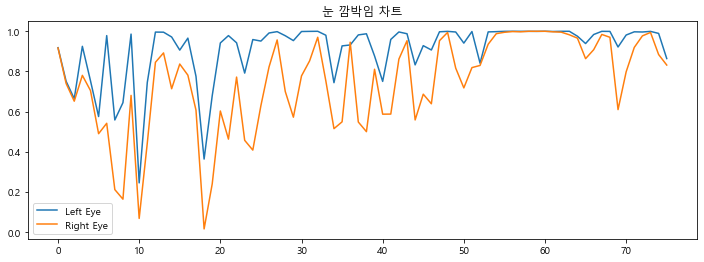

In [57]:
arr = np.array(frame_index)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
%matplotlib inline
import matplotlib.pyplot as plt
resultlist = []
for i in range(0,len(arr)//24):
    left = 0
    right = 0
    for j in range(i*24,(i+1)*24):
        left = left+arr[j,1]
        right = right+arr[j,2]
    resultlist.append([j,left/24,right/24])
resultarr = np.array(resultlist)
plt.figure(figsize=(12, 4))
plt.title('눈 깜박임 차트')
plt.plot(resultarr[:,1])
plt.plot(resultarr[:,2])
plt.legend(['Left Eye','Right Eye'])

# 결과 영상 저장 하기

In [59]:
result_cap = cv2.VideoCapture(resultpath)
result_cap_length, result_cap_width, result_cap_height, result_cap_fps_n = get_mspec(result_cap)
print(result_cap_length, result_cap_width, result_cap_height, result_cap_fps_n)
result_cap.release()

# sync를 위한 fps 계산
duration = cap_length/cap_fps_n
final_fps_n=result_cap_length/duration

1837 360 202 24.0
24.0 76.54166666666667


In [60]:
# 중간 비디오클립의 ftp 맞추기
videoclip = mpe.VideoFileClip(resultpath)
orig_clip = mpe.VideoFileClip(video_output)
audioclip = orig_clip.audio
final_clip = videoclip.set_audio(audioclip)
final_clip.write_videofile("a.mp4")

Moviepy - Building video a.mp4.
MoviePy - Writing audio in aTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video a.mp4



Moviepy - Done !
Moviepy - video ready a.mp4
